This notebook walks through train/test splitting, baseline models, walk-forward validation, SARIMA, LSTM, and hyperparameter tuning for Tesla monthly return forecasting, with error fixes and enhancements.

## Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import xgboost as xgb
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm

# Set plotting style
sns.set_theme(style="whitegrid")

# Configure TensorFlow for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-07-03 10:29:12.647825: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 10:29:12.941879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 10:29:12.943938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-03 10:29:14.480364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Features and Prepare Target

In [13]:
# Load engineered features from CSV
df = pd.read_csv('../data/processed/tsla_features.csv', index_col='Date', parse_dates=True)
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns of features.")

# Compute 21-day forward return as our target variable
df['target'] = df['Close'].shift(-21) / df['Close'] - 1
# Drop last 21 rows (no target)
df = df.dropna(subset=['target'])

# Remove any stray index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Separate features and target
X = df.drop(columns=['target'])
y = df['target']

Loaded 2253 rows and 19 columns of features.


## Train/Test Split

In [4]:
# 80/20 chronological split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1785, 18), Test shape: (447, 18)


### Evaluation Utilities

In [15]:
def evaluate_model(name, y_true, y_pred):
    ml_abs = mean_absolute_error(y_true, y_pred)
    ml_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    ml_r2 = r2_score(y_true, y_pred)
    dir_acc = accuracy_score((y_true > 0), (y_pred > 0))
    print(f"{name} -> MAE: {ml_abs:.4f}, RMSE: {ml_rmse:.4f}, R2: {ml_r2:.4f}, DirAcc: {dir_acc:.4f}")
    return {'model': name, 'MAE': ml_abs, 'RMSE': ml_rmse, 'R2': ml_r2, 'DirAcc': dir_acc}

### Baseline Models

In [16]:
results = []

# 5.1 Naïve predictor: last available 21-day return
y_pred_naive = X_test['return_21']
results.append(evaluate_model('Naive', y_test, y_pred_naive))

# Select core features and one-hot encode month for models
features = ['return_1', 'return_5', 'rsi', 'vol_ratio_20', 'month']
def prep_X(df_in):
    df_sub = df_in[features].copy()
    return pd.get_dummies(df_sub, columns=['month'], drop_first=True)

X_tr_sub = prep_X(X_train)
X_te_sub = prep_X(X_test)

# 5.2 Linear Regression
lr = LinearRegression().fit(X_tr_sub, y_train)
results.append(evaluate_model('LinearRegression', y_test, lr.predict(X_te_sub)))

# 5.3 Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_tr_sub, y_train)
results.append(evaluate_model('RandomForest', y_test, rf.predict(X_te_sub)))

# 5.4 XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse', use_label_encoder=False)
xgb_model.fit(X_tr_sub, y_train)
results.append(evaluate_model('XGBoost', y_test, xgb_model.predict(X_te_sub)))

Naive -> MAE: 0.2526, RMSE: 0.3336, R2: -1.3289, DirAcc: 0.4564
LinearRegression -> MAE: 0.1746, RMSE: 0.2240, R2: -0.0505, DirAcc: 0.5257
RandomForest -> MAE: 0.1787, RMSE: 0.2300, R2: -0.1074, DirAcc: 0.5034
XGBoost -> MAE: 0.1886, RMSE: 0.2407, R2: -0.2127, DirAcc: 0.5034


Baseline Visualizations

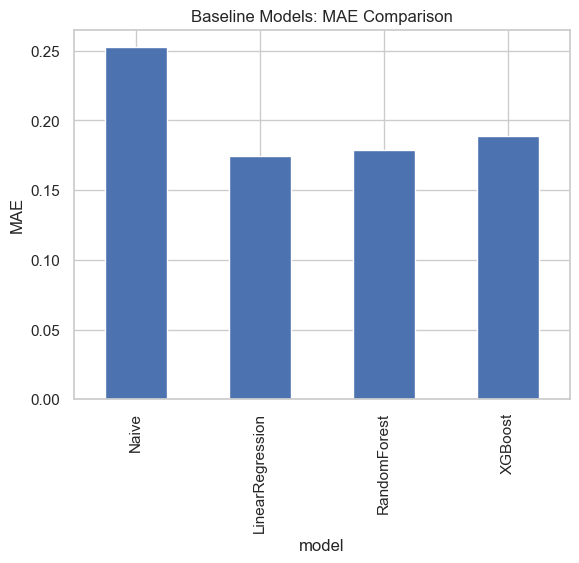

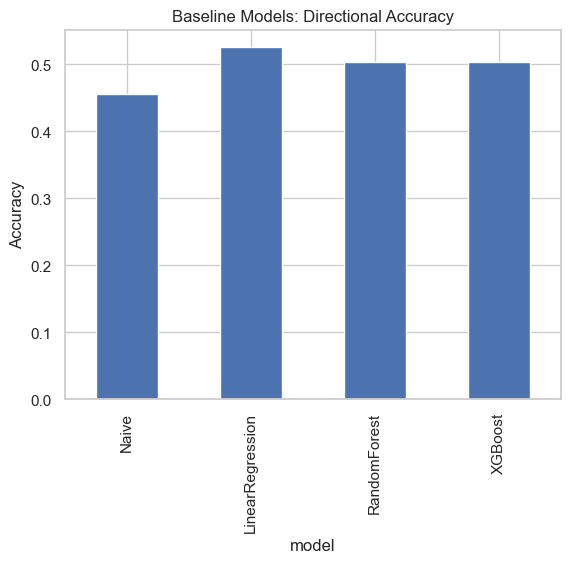

In [17]:
# Aggregate baseline results for visualization
df_base = pd.DataFrame(results).set_index('model')

# Plot MAE comparison
df_base['MAE'].plot.bar(title='Baseline Models: MAE Comparison')
plt.ylabel('MAE')
plt.show()

# Plot Directional Accuracy
df_base['DirAcc'].plot.bar(title='Baseline Models: Directional Accuracy')
plt.ylabel('Accuracy')
plt.show()

### Walk-Forward Validation (XGBoost)

In [18]:
wf_results = []
cv = TimeSeriesSplit(n_splits=5)
for tr_idx, val_idx in cv.split(X, y):
    X_tr, X_val = prep_X(X.iloc[tr_idx]), prep_X(X.iloc[val_idx])
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    m = xgb.XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse', use_label_encoder=False)
    m.fit(X_tr, y_tr)
    wf_results.append(evaluate_model('XGB_WF', y_val, m.predict(X_val)))

# Aggregate
df_wf = pd.DataFrame(wf_results).set_index('model')
print('Walk-forward mean metrics:')
print(df_wf.mean())

XGB_WF -> MAE: 0.0991, RMSE: 0.1258, R2: -0.5371, DirAcc: 0.5296
XGB_WF -> MAE: 0.1249, RMSE: 0.1550, R2: -0.4505, DirAcc: 0.4624
XGB_WF -> MAE: 0.2582, RMSE: 0.3245, R2: -0.5694, DirAcc: 0.5376
XGB_WF -> MAE: 0.1549, RMSE: 0.1968, R2: -0.4515, DirAcc: 0.5108
XGB_WF -> MAE: 0.1929, RMSE: 0.2453, R2: -0.1939, DirAcc: 0.4785
Walk-forward mean metrics:
MAE       0.165983
RMSE      0.209492
R2       -0.440499
DirAcc    0.503763
dtype: float64


### SARIMA Model

In [19]:
# Prepare monthly returns
daily_close = df['Close']
monthly_close = daily_close.resample('M').last()
monthly_ret = monthly_close.pct_change().shift(-1).dropna()

# Split
i = int(len(monthly_ret)*0.8)
t_train, t_test = monthly_ret.iloc[:i], monthly_ret.iloc[i:]

# Fit SARIMA
sarima_mod = sm.tsa.SARIMAX(t_train, order=(1,1,1), seasonal_order=(1,1,1,12))
res = sarima_mod.fit(disp=False)
pred_s = res.predict(start=t_test.index[0], end=t_test.index[-1]).reindex(t_test.index)

# Evaluate
sarima_res = evaluate_model('SARIMA', t_test, pred_s)

/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA -> MAE: 0.2139, RMSE: 0.2471, R2: -0.5453, DirAcc: 0.3636


### LSTM Model

In [22]:
# Prepare sequences
seq_features = features.copy()
window = 30

X_arr, y_arr = [], []
for i in range(window, len(X)):
    seq = X.iloc[i-window:i][seq_features].values
    X_arr.append(seq)
    y_arr.append(y.iloc[i])
X_arr, y_arr = np.array(X_arr), np.array(y_arr)

# Train/test split
split = int(len(X_arr)*0.8)
X_tr, X_te = X_arr[:split], X_arr[split:]
y_tr, y_te   = y_arr[:split], y_arr[split:]

# Build LSTM
model = Sequential([
    LSTM(32, input_shape=(window, len(seq_features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_tr, y_tr, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Predict
y_pred_lstm = model.predict(X_te).flatten()
# Align with dates
dates_te = X.index[window+split:]
results.append(evaluate_model('LSTM', pd.Series(y_te, index=dates_te), pd.Series(y_pred_lstm, index=dates_te)))

14/14 [==============================] - 1s 6ms/step
LSTM -> MAE: 0.1782, RMSE: 0.2203, R2: -0.0215, DirAcc: 0.4853


### Hyperparameter Tuning (XGBoost)

In [23]:
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.1,0.2],
    'subsample': [0.6,0.8,1.0]
}
rs = RandomizedSearchCV(
    xgb.XGBRegressor(eval_metric='rmse', use_label_encoder=False, random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)
rs.fit(prep_X(X), y)
best_xgb = rs.best_estimator_
print(f"Best hyperparameters: {rs.best_params_}")

# Evaluate tuned model on hold-out
tuned_pred = best_xgb.predict(prep_X(X_test))
tuned_res = evaluate_model('XGB_Tuned', y_test, tuned_pred)
results.append(tuned_res)

Best hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
XGB_Tuned -> MAE: 0.1403, RMSE: 0.1810, R2: 0.3141, DirAcc: 0.6331


### Summary of Results

                       MAE      RMSE        R2    DirAcc
model                                                   
Naive             0.252553  0.333575 -1.328888  0.456376
LinearRegression  0.174635  0.224040 -0.050546  0.525727
RandomForest      0.178662  0.230020 -0.107375  0.503356
XGBoost           0.188647  0.240707 -0.212666  0.503356
LSTM              0.178160  0.220274 -0.021492  0.485261
XGB_Tuned         0.140270  0.181028  0.314107  0.633110
XGB_WF            0.099065  0.125804 -0.537111  0.529570
SARIMA            0.213910  0.247138 -0.545298  0.363636


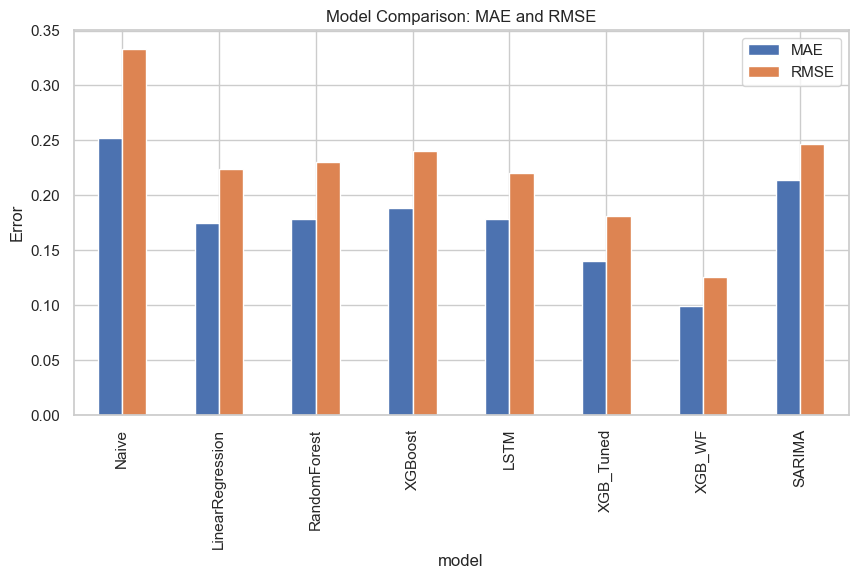

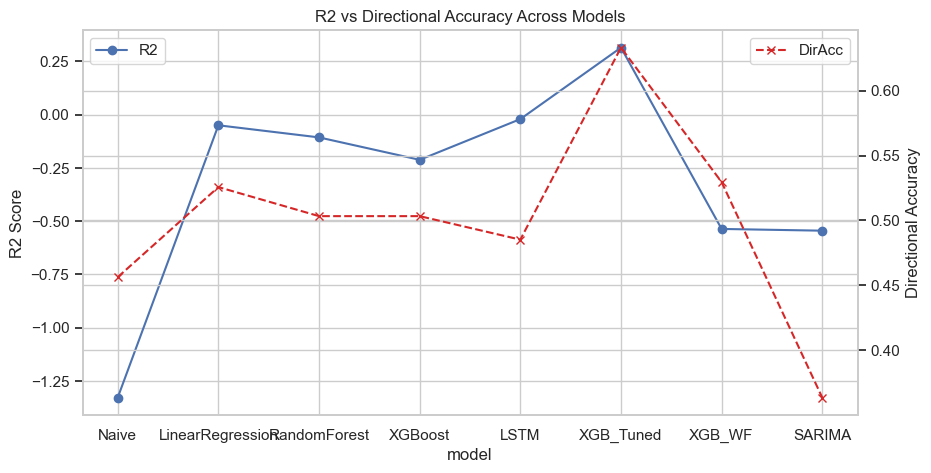

In [25]:
# Combine all results into DataFrame
all_res = results + wf_results + [sarima_res, tuned_res]
df_res = pd.DataFrame(all_res).drop_duplicates('model').set_index('model')
print(df_res)

# Visualization: MAE and RMSE side by side
df_res[['MAE','RMSE']].plot.bar(
    figsize=(10,5),
    title='Model Comparison: MAE and RMSE'
)
plt.ylabel('Error')
plt.show()

# Visualization: R2 and Directional Accuracy
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

df_res['R2'].plot(ax=ax1, marker='o', label='R2')
df_res['DirAcc'].plot(ax=ax2, marker='x', linestyle='--', label='DirAcc', color='tab:red')

ax1.set_ylabel('R2 Score')
ax2.set_ylabel('Directional Accuracy')
ax1.set_title('R2 vs Directional Accuracy Across Models')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()